## POS Tagging - Encoder Decoder

### Imports

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from tqdm import tqdm
import numpy as np
import nltk
# from gensim.models import Word2Vec
import gensim.downloader as api
import random
import json
# For evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Download the dataset if you haven't already
nltk.download('brown', quiet=True)
nltk.download('universal_tagset', quiet=True)

# Set a random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### Data Loading and Pre-processing

In [29]:
# Load the Brown corpus with the universal tagset
corpus = nltk.corpus.brown.tagged_sents(tagset='universal')

# --- 1. Create Vocabularies ---
all_words = [word.lower() for sent in corpus for word, tag in sent]
all_tags = [tag for sent in corpus for word, tag in sent]

word_counts = Counter(all_words)
tag_counts = Counter(all_tags)

# Create word and tag to index mappings
# Add special tokens: <PAD> for padding, <UNK> for unknown words
word_to_idx = {word: i+2 for i, (word, _) in enumerate(word_counts.items())}
word_to_idx['<PAD>'] = 0
word_to_idx['<UNK>'] = 1

tag_to_idx = {tag: i+1 for i, (tag, _) in enumerate(tag_counts.items())}
tag_to_idx['<PAD>'] = 0

# Create index to tag mapping for later use in evaluation
idx_to_tag = {i: tag for tag, i in tag_to_idx.items()}

# --- 2. Convert Sentences to Indices and Pad ---
def preprocess(corpus, word_to_idx, tag_to_idx):
    sequences = []
    for sent in corpus:
        word_indices = [word_to_idx.get(word.lower(), word_to_idx['<UNK>']) for word, tag in sent]
        tag_indices = [tag_to_idx[tag] for word, tag in sent]
        sequences.append((word_indices, tag_indices))
    return sequences

sequences = preprocess(corpus, word_to_idx, tag_to_idx)

# Find max sequence length for padding
MAX_LEN = max(len(s) for s, t in sequences)
print(f"Maximum sentence length: {MAX_LEN}")

def pad_sequences(sequences, max_len, pad_idx):
    padded_sents = []
    padded_tags = []
    for s, t in sequences:
        padded_s = s + [pad_idx] * (max_len - len(s))
        padded_t = t + [pad_idx] * (max_len - len(t))
        padded_sents.append(padded_s)
        padded_tags.append(padded_t)
    return np.array(padded_sents), np.array(padded_tags)

padded_sents, padded_tags = pad_sequences(sequences, MAX_LEN, word_to_idx['<PAD>'])

# --- 3. Train, Validation, Test Split ---
X_train, X_test, y_train, y_test = train_test_split(padded_sents, padded_tags, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED) # 0.1 * 0.8 = 0.08

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")


# --- 4. Create PyTorch Dataset and DataLoader ---
class PosTaggingDataset(Dataset):
    def __init__(self, sentences, tags):
        self.sentences = torch.LongTensor(sentences)
        self.tags = torch.LongTensor(tags)

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx], self.tags[idx]

train_dataset = PosTaggingDataset(X_train, y_train)
val_dataset = PosTaggingDataset(X_val, y_val)
test_dataset = PosTaggingDataset(X_test, y_test)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Maximum sentence length: 180
Train size: 41284
Validation size: 4588
Test size: 11468


### fastText Embeddings

In [30]:
# --- Create Embedding Matrix from Pre-trained fastText ---

EMBEDDING_DIM = 300 # IMPORTANT: This must match the pre-trained model's dimension
# print("Loading fastText model... (This may take a few minutes on first download)")
ft_model = api.load("fasttext-wiki-news-subwords-300")
print("Model loaded.")

# 2. Create the embedding matrix for our vocabulary
vocab_size = len(word_to_idx)
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_to_idx.items():
    if word in ft_model:
        embedding_matrix[i] = ft_model[word]
    # fastText can generate vectors for OOV words, but for simplicity
    # we'll stick to the known vocab here. The real power is in its
    # internal handling of word variations.

embedding_matrix = torch.FloatTensor(embedding_matrix).to(device)
print("fastText embedding matrix created.")

# IMPORTANT: Remember to update the HIDDEN_DIM and other model parameters
# if changing the EMBEDDING_DIM from 100 to 300.
# ...
# ENC_EMB_DIM = EMBEDDING_DIM # This will now be 300
# HIDDEN_DIM = 256 # You might want to increase this as well
# ...

Model loaded.
fastText embedding matrix created.


In [31]:
embedding_matrix.shape

torch.Size([49817, 300])

### LSTM Block

$$
\begin{aligned}
i_t &= \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
f_t &= \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
g_t &= \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
o_t &= \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
c_t &= f_t \odot c_{t-1} + i_t \odot g_t \\
h_t &= o_t \odot \tanh(c_t)
\end{aligned}
$$


In [32]:
#LSTM Class

class LSTMCell(nn.Module):
    """A from-scratch implementation of a single LSTM cell."""
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.hidden_size = hidden_size
        
        # Linear transformations for input and hidden state for all 4 gates
        # This is more efficient than 4 separate Linear layers.
        self.linear_ih = nn.Linear(input_size, 4 * hidden_size)
        self.linear_hh = nn.Linear(hidden_size, 4 * hidden_size)

    def forward(self, x, states):
        # x: (batch_size, input_size)
        # states: tuple (h_prev, c_prev)
        # h_prev, c_prev: (batch_size, hidden_size)
        h_prev, c_prev = states

        # Compute all gate values at once
        gates = self.linear_ih(x) + self.linear_hh(h_prev)
        
        # Split the gates into input, forget, cell, and output gates
        # Each chunk has size (batch_size, hidden_size)
        i, f, g, o = gates.chunk(4, dim=1)

        # Apply activation functions
        i_t = torch.sigmoid(i) # Input gate
        f_t = torch.sigmoid(f) # Forget gate
        g_t = torch.tanh(g)    # Cell gate (candidate cell state)
        o_t = torch.sigmoid(o) # Output gate

        # Update the cell state
        c_t = f_t * c_prev + i_t * g_t
        
        # Update the hidden state
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t

### The Encoder

The encoder takes an input sequence and processes it step-by-step with our LSTMCell, producing a final "context" vector (the last hidden and cell states)

In [33]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Embedding layer
        self.embedding = nn.Embedding(input_dim, emb_dim)
        # We can initialize with our Word2Vec weights
        self.embedding.weight.data.copy_(embedding_matrix)
        self.embedding.weight.requires_grad = False
        
        # --- ADD DROPOUT LAYER ---
        self.dropout = nn.Dropout(dropout)

        # We will use our custom LSTM cell
        self.lstm_cells = nn.ModuleList([LSTMCell(emb_dim if i == 0 else hidden_dim, hidden_dim) for i in range(n_layers)])

    def forward(self, src):
        # src: (batch_size, seq_len)
        batch_size, seq_len = src.shape
        embedded = self.embedding(src)
        
        # --- APPLY DROPOUT AFTER EMBEDDING ---
        embedded = self.dropout(embedded)
        
        # Initialize hidden and cell states as lists of tensors for each layer
        h_states = [torch.zeros(batch_size, self.hidden_dim).to(device) for _ in range(self.n_layers)]
        c_states = [torch.zeros(batch_size, self.hidden_dim).to(device) for _ in range(self.n_layers)]
        
        # Process sequence one token at a time
        input_for_lstm = embedded.permute(1, 0, 2) # (seq_len, batch_size, emb_dim)
        
        for t in range(seq_len):
            input_t = input_for_lstm[t] # (batch_size, emb_dim)
            for i, layer in enumerate(self.lstm_cells):
                # Update the states in the list (this is not an inplace operation)
                h_states[i], c_states[i] = layer(input_t, (h_states[i], c_states[i]))
                # Apply dropout to the hidden state before passing to the next layer
                if i < self.n_layers - 1: # Don't apply dropout on the final layer's output
                     input_t = self.dropout(h_states[i])
                else:
                     input_t = h_states[i]
        
        # Stack the lists to create the final context tensors
        return torch.stack(h_states), torch.stack(c_states)



### Decoder

The decoder takes the encoder's context and generates the output sequence (the POS tags) one tag at a time. It uses the previously predicted tag as input for the next prediction

In [34]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        # --- ADDED DROPOUT LAYER ---
        self.dropout = nn.Dropout(dropout)
        
        self.lstm_cells = nn.ModuleList([LSTMCell(emb_dim if i == 0 else hidden_dim, hidden_dim) for i in range(n_layers)])
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, input, hidden, cell):
        hidden_states = list(hidden.unbind(0))
        cell_states = list(cell.unbind(0))

        input = input.unsqueeze(0)
        embedded = self.embedding(input).squeeze(0)
        
        # --- APPLY DROPOUT AFTER EMBEDDING ---
        embedded = self.dropout(embedded)
        
        input_for_layer = embedded
        for i, layer in enumerate(self.lstm_cells):
            hidden_states[i], cell_states[i] = layer(input_for_layer, (hidden_states[i], cell_states[i]))
            # Apply dropout to the hidden state before passing to the next layer or final output
            if i < self.n_layers - 1:
                input_for_layer = self.dropout(hidden_states[i])
            else:
                input_for_layer = hidden_states[i]
            
        h_new = torch.stack(hidden_states)
        c_new = torch.stack(cell_states)

        prediction = self.fc_out(h_new[-1])
        
        return prediction, h_new, c_new

### The Full Encoder-Decoder (Seq2Seq) Model

This class ties the Encoder and Decoder together. It includes "teacher forcing," a technique where we feed the ground-truth tag to the decoder during training to stabilize learning

In [35]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src: (batch_size, src_len)
        # trg: (batch_size, trg_len)
        batch_size, trg_len = trg.shape
        trg_vocab_size = self.decoder.output_dim
        
        # To store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # Encoder forward pass
        hidden, cell = self.encoder(src)
        
        # Decoder's first input is the <PAD> token (or a <SOS> token if we used one)
        input = trg[:, 0]
        
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            
            # Decide whether to use teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) # Get the predicted tag
            
            # If teacher forcing, use actual next token as next input
            # otherwise, use predicted token
            input = trg[:, t] if teacher_force else top1
            
        return outputs.permute(1, 0, 2) # (batch_size, seq_len, output_dim)

### Model Training



In [38]:
# --- Hyperparameters ---
INPUT_DIM = len(word_to_idx)
OUTPUT_DIM = len(tag_to_idx)
ENC_EMB_DIM = EMBEDDING_DIM 
DEC_EMB_DIM = 100           
HIDDEN_DIM = 256           
N_LAYERS = 2
DROPOUT = 0.4 
N_EPOCHS = 10
CLIP = 1

# --- Model Initialization ---
encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
model = EncoderDecoder(encoder, decoder, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

# --- Loss and Optimizer ---
PAD_IDX = tag_to_idx['<PAD>']
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters())


# --- Training and Evaluation Loops ---
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, (src, trg) in enumerate(tqdm(iterator, desc="Training")):
        src, trg = src.to(device), trg.to(device)
        
        optimizer.zero_grad()
        output = model(src, trg) 
        
        output_dim = output.shape[-1]
        # --- CORRECTED THIS LINE ---
        output = output[:, 1:].reshape(-1, output_dim) 
        trg = trg[:, 1:].reshape(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (src, trg) in enumerate(tqdm(iterator, desc="Evaluating")):
            src, trg = src.to(device), trg.to(device)
            
            output = model(src, trg, 0) 
            
            output_dim = output.shape[-1]
            # --- CORRECTED THIS LINE ---
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()
            
    return epoch_loss / len(iterator)

# --- Start Training ---
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_loader, criterion)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'pos-tagger-model.pt')
        
    print(f'\nEpoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')


Evaluating: 100%|██████████| 72/72 [00:49<00:00,  1.47it/s]



Epoch: 01
	Train Loss: 2.036
	 Val. Loss: 2.111


Evaluating: 100%|██████████| 72/72 [00:58<00:00,  1.24it/s]



Epoch: 02
	Train Loss: 1.934
	 Val. Loss: 2.114


Evaluating: 100%|██████████| 72/72 [01:00<00:00,  1.19it/s]



Epoch: 03
	Train Loss: 1.917
	 Val. Loss: 2.115


Training:  22%|██▏       | 144/646 [05:44<19:59,  2.39s/it]


KeyboardInterrupt: 

### Evaluation

Testing: 100%|██████████| 180/180 [01:02<00:00,  2.90it/s]



--- Classification Report ---
              precision    recall  f1-score   support

         DET       0.26      0.04      0.07     25007
        NOUN       0.26      0.82      0.39     53194
         ADJ       0.00      0.00      0.00     16361
        VERB       0.37      0.19      0.25     36269
         ADP       0.14      0.04      0.06     27402
           .       0.20      0.13      0.16     28512
         ADV       0.00      0.00      0.00     10169
        CONJ       0.00      0.00      0.00      6934
         PRT       0.00      0.00      0.00      5450
        PRON       0.19      0.04      0.06      8128
         NUM       0.00      0.00      0.00      2716
           X       0.00      0.00      0.00       317

    accuracy                           0.26    220459
   macro avg       0.12      0.10      0.08    220459
weighted avg       0.20      0.26      0.17    220459



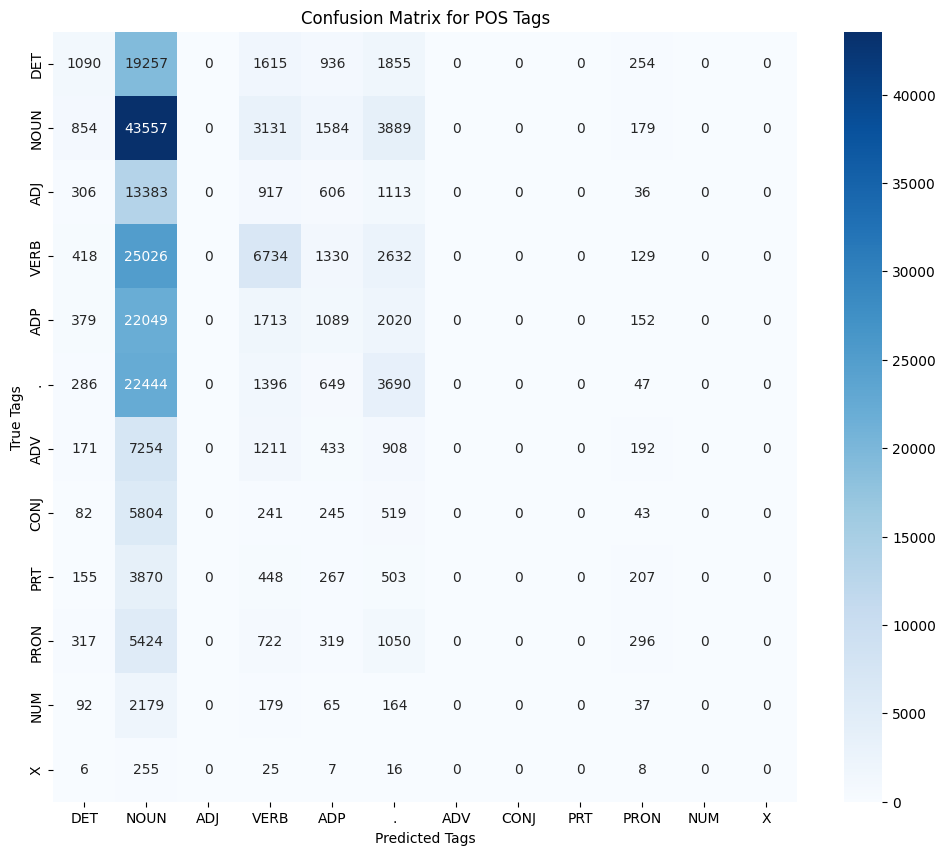


Example tagging for: 'the old man the boat'
[('the', 'NOUN'), ('old', '.'), ('man', 'NOUN'), ('the', '.'), ('boat', '.')]


In [37]:
# Load the best model
model.load_state_dict(torch.load('pos-tagger-model.pt'))

def get_predictions(model, iterator):
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for i, (src, trg) in enumerate(tqdm(iterator, desc="Testing")):
            src, trg = src.to(device), trg.to(device)
            
            output = model(src, trg, 0) # No teacher forcing
            
            # Get predictions (argmax) and flatten
            preds = output.argmax(dim=2)
            
            # Flatten and ignore padding for evaluation
            for j in range(trg.shape[0]):
                true_tags = trg[j, 1:] # Ignore first tag
                pred_tags = preds[j, 1:]
                
                # Find where the actual sentence ends (before padding)
                true_len = (true_tags != PAD_IDX).sum()
                
                all_true.extend(true_tags[:true_len].cpu().numpy())
                all_preds.extend(pred_tags[:true_len].cpu().numpy())
                
    return all_true, all_preds

true_tags, pred_tags = get_predictions(model, test_loader)

# Convert indices back to tag names
true_labels = [idx_to_tag[t] for t in true_tags]
pred_labels = [idx_to_tag[p] for p in pred_tags]
tag_names = [tag for tag, i in tag_to_idx.items() if i != PAD_IDX]

# --- 1. Classification Report (Precision, Recall, F1-Score) ---
report = classification_report(true_labels, pred_labels, labels=tag_names, zero_division=0)
print("\n--- Classification Report ---")
print(report)

# --- 2. Confusion Matrix ---
conf_matrix = confusion_matrix(true_labels, pred_labels, labels=tag_names)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=tag_names, yticklabels=tag_names)
plt.xlabel('Predicted Tags')
plt.ylabel('True Tags')
plt.title('Confusion Matrix for POS Tags')
plt.show()

# Example of a prediction
def tag_sentence(sentence, model, word_to_idx, idx_to_tag, device, max_len):
    model.eval()
    
    # Tokenize and numericalize
    tokens = [word.lower() for word in sentence.split(' ')]
    indices = [word_to_idx.get(token, word_to_idx['<UNK>']) for token in tokens]
    
    # Pad
    padded_indices = indices + [word_to_idx['<PAD>']] * (max_len - len(indices))
    src_tensor = torch.LongTensor(padded_indices).unsqueeze(0).to(device)
    
    # Create a dummy target tensor
    trg_tensor = torch.zeros_like(src_tensor).to(device)
    
    with torch.no_grad():
        output = model(src_tensor, trg_tensor, 0)
    
    pred_tags_indices = output.argmax(2).squeeze(0).cpu().numpy()
    pred_tags = [idx_to_tag[i] for i in pred_tags_indices[1:len(tokens)+1]]
    
    return list(zip(tokens, pred_tags))
    
# Test a sentence
test_sentence = "the old man the boat"
tagged_sentence = tag_sentence(test_sentence, model, word_to_idx, idx_to_tag, device, MAX_LEN)
print(f"\nExample tagging for: '{test_sentence}'")
print(tagged_sentence)

In [ ]:
# # --- ADD THIS CODE TO THE END OF YOUR TRAINING SCRIPT ---

# print("\n--- Saving artifacts for deployment ---")

# # 1. Save the word-to-index and tag-to-index mappings
# artifacts = {
#     'word_to_idx': word_to_idx,
#     'tag_to_idx': tag_to_idx,
#     'MAX_LEN': MAX_LEN
# }

# with open('artifacts.json', 'w') as f:
#     json.dump(artifacts, f, indent=4)

# # 2. The model is already saved as 'pos-tagger-model.pt' in the training loop

# print("Artifacts saved to 'artifacts.json'")
# print("Model saved to 'pos-tagger-model.pt'")
# print("Ready for Gradio deployment.")